In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from hinge_feature_extraction import * 
from cold_feature_extraction  import * 
from PIL import Image, ImageEnhance
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from threading import Thread
from multiprocessing.pool import ThreadPool
import pickle
import time 

### Reading handwritten images from file and store it with it's lable 
for male y =0 and for female y =1

In [2]:
# feature extraction parameters
opt = {
        'sharpness_factor': 10,
        'bordersize': 3,
        'show_images': False,
        'is_binary': False,
    }

In [3]:
hinge_feature_vector = []
cold_feature_vector =[]
y_data =[]
Hinge_Model_name  ="SVM_HINGE_MODEL"
Cold_Model_name ="SVM_COLD_MODEL"
cold = Cold(opt)
hinge = Hinge(opt)

In [4]:
lables = ["Males" , "Females"]

def feature_extraction(filename):
    currentDirectory = os.getcwd()

    # for each class we read it's data 
    for lable in lables:
         directory = filename+"\\"+ lable+"\\"+lable+"\\"
         path =os.path.join(currentDirectory, directory)
         class_lable = lables.index(lable)
         print(str(class_lable) + "-Start ..")
         for imagename in tqdm(os.listdir(path)):
            try:
                img_path = os.path.join(path, imagename)
                im = Image.open(img_path)
                hinge_f = hinge.get_hinge_features(im)
                cold_f = cold.get_cold_features(im)

                hinge_feature_vector.append(hinge_f)
                cold_feature_vector.append(cold_f)
                y_data.append(class_lable)
            except Exception as e :
                print (e)



In [5]:
def svm_model_training (x_train , y_train, C_ =10.0):
    
    # using standart scaler for data transfromation
    scaler = StandardScaler()
    xtrain = scaler.fit_transform(x_train)
    
    #converting any nan value to number 
    xtrain = np.nan_to_num(xtrain)

    # geting our svm model from sklearn for train it with 
    # feature data and lable data
    clf = SVC(kernel='rbf', verbose=True, C= C_)
    clf.fit(xtrain, y_train)

    y_pred = clf.predict(xtrain)
    return clf , y_pred


In [6]:
def save_model (model , model_name):
    filename = model_name+'.sav'
    pickle.dump(model, open(filename, 'wb'))
def load_model (model_name):
    filename = model_name+'.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [22]:
def model_pipeline_testing(filename ,clf_H_name = Hinge_Model_name,clf_C_name=Cold_Model_name):
    '''
        This function responsible for testing our models
        we have to svm models one for cold feature and one for hinge feature 
        clf_H trained model with Hinge feature 
        clf_C trained model with Cold feature 
    '''
    
    result_file = open("results.txt" ,"w")
    time_file = open("time.txt" , "w")
    
    # loading trained models 
    clf_H = load_model(clf_H_name)
    clf_C = load_model(clf_C_name)
    hinge_f_vector=[]
    cold_f_vector=[]
    currentDirectory = os.getcwd()
    directory = filename+"\\"
    path =os.path.join(currentDirectory, directory)
    for imagename in (os.listdir(path)):
            try:
                
                # for each image in the path 
                img_path = os.path.join(path, imagename)
                im = Image.open(img_path)
                start = time.time()
                # getting image cold and hinge feature 
                hinge_f = hinge.get_hinge_features(im)
                cold_f = cold.get_cold_features(im)
                #storing it in the feature vectors 
                end = time.time()
                time_file.write(str(end-start) +"\n")
                hinge_f_vector.append(hinge_f)
                cold_f_vector.append(cold_f)
            except Exception as e :
                    print (e)
    # using trained model for hinge and cold 
    y_pred_hinge =clf_H.predict(hinge_f_vector)
    y_pred_cold  =clf_C.predict(cold_f_vector)
    y_pred = np.maximum(y_pred_hinge, y_pred_cold)
    for i in y_pred:
        result_file.write(str(i) +"\n")
    result_file.close()
    time_file.close()

In [8]:
def model_evaluation (y_test , y_predict , Lable ="Testing"):
    # testing our model using confusion matrix 
    cf = confusion_matrix(y_test, y_predict)
    cf_sum = cf.sum(axis = 1)[:, np.newaxis]
    cf = np.round(cf / cf_sum * 100, 2)
    float_formatter = "{:.2f}".format
    np.set_printoptions(formatter={'float_kind':float_formatter})    
    cr = 0.0
    for i in range(0, cf.shape[0]):
            cr += cf[i][i]

    cr /= cf.shape[0]
    print('classification rate '+Lable +' = '+ str(np.round(cr, 2)))

    print(classification_report(y_test, y_predict))
    print('Confusion Matrix ' + Lable + " Data")
    
    print(repr(cf))
    sns.heatmap(cf, annot=True,  fmt='', cmap='Blues')

In [9]:

data = feature_extraction("data_set") 


0-Start ..


  0%|                                                                                          | 0/232 [00:00<?, ?it/s]C:\Users\Yousif-Ahmed\gender-classification\cold_feature_extraction.py:115: RuntimeWarning: divide by zero encountered in log10
  rhos_log_space = np.log10(rhos)
100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [15:02<00:00,  3.89s/it]


1-Start ..


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [07:52<00:00,  3.61s/it]


## Spliting The Data With Randomness   

In [10]:
feature_vector = np.concatenate((hinge_feature_vector,cold_feature_vector) , axis=1)
np.shape(hinge_feature_vector) , np.shape(cold_feature_vector) , feature_vector.shape
hinge_max = np.shape(hinge_feature_vector)[1]


In [11]:
x_train , x_test , y_train , y_test = train_test_split(feature_vector ,y_data , test_size =0.20 , random_state =40)


##  Training Data Visualization

C:\Users\Yousif-Ahmed\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

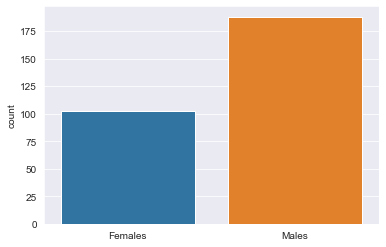

In [12]:
lables = []
for i in y_train:
    if(i == 0):
        lables.append("Males")
    else:
        lables.append("Females")
sns.set_style('darkgrid')
sns.countplot(lables)


## Training and Testing The Model With Hinge Feature 


In [13]:

x_hinge_train = x_train[:,:hinge_max]
x_hinge_test = x_test[:,:hinge_max]

scaler = StandardScaler()
xtest = scaler.fit_transform(x_hinge_test)
xtest = np.nan_to_num(xtest)


clf_H , y_pred_hinge = svm_model_training (x_hinge_train , y_train)
y_pred_hinge_test = clf_H.predict(xtest)
save_model (clf_H , Hinge_Model_name)
print(clf_H)

[LibSVM]SVC(C=10.0, verbose=True)


## Training and Testing The Model With Cold Feature

In [14]:
x_cold_train = x_train[:,hinge_max:]
x_cold_test = x_test[:,hinge_max:]

scaler = StandardScaler()
xtest = scaler.fit_transform(x_cold_test)
xtest = np.nan_to_num(xtest)



clf_C ,y_pred_cold = svm_model_training(x_cold_train , y_train)
y_pred_cold_test = clf_C.predict(xtest)

save_model (clf_C , Cold_Model_name)
print(clf_C)

[LibSVM]SVC(C=10.0, verbose=True)


In [15]:
y_pred = np.maximum(y_pred_hinge, y_pred_cold)
y_pred_test =np.maximum(y_pred_hinge_test, y_pred_cold_test)

## Model Evaluation

classification rate Training = 99.47
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       188
           1       0.98      1.00      0.99       102

    accuracy                           0.99       290
   macro avg       0.99      0.99      0.99       290
weighted avg       0.99      0.99      0.99       290

Confusion Matrix Training Data
array([[98.94, 1.06],
       [0.00, 100.00]])


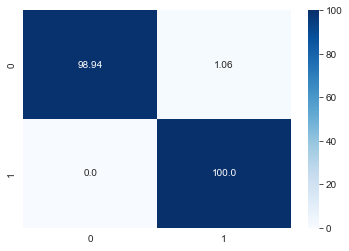

In [16]:
model_evaluation(y_train , y_pred , "Training")

classification rate Testing = 77.11
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        44
           1       0.72      0.72      0.72        29

    accuracy                           0.78        73
   macro avg       0.77      0.77      0.77        73
weighted avg       0.78      0.78      0.78        73

Confusion Matrix Testing Data
array([[81.82, 18.18],
       [27.59, 72.41]])


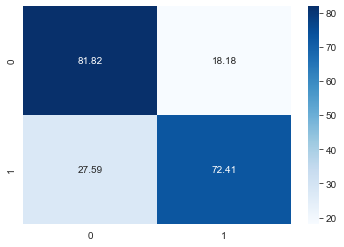

In [17]:
model_evaluation(y_test , y_pred_test , "Testing" )

In [23]:
y_pred =model_pipeline_testing("test")

C:\Users\Yousif-Ahmed\gender-classification\cold_feature_extraction.py:115: RuntimeWarning: divide by zero encountered in log10
  rhos_log_space = np.log10(rhos)
